# Kalman mid-price

The Kalman mid-price is a concept used in algorithmic trading to estimate a more accurate mid-price (the average of the bid and ask prices) of a financial instrument. This is done using the Kalman filter, a mathematical algorithm that provides an efficient way to estimate the state of a process in a way that minimizes the mean of the squared error.

### 1. Importing Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pykalman import KalmanFilter
import numpy as np

### 2. Load the orderbook data from Lobster
This dataframe containes the information regarding the evolution of the order book for APPL stocks.

Prices are in Dollar times 10000 (i.e., A stock price of $91.14 is given by 911400)

In [2]:
columns = [
    "Ask_Price_1", "Ask_Size_1", "Bid_Price_1", "Bid_Size_1",
    "Ask_Price_2", "Ask_Size_2", "Bid_Price_2", "Bid_Size_2",
    "Ask_Price_3", "Ask_Size_3", "Bid_Price_3", "Bid_Size_3",
    "Ask_Price_4", "Ask_Size_4", "Bid_Price_4", "Bid_Size_4",
    "Ask_Price_5", "Ask_Size_5", "Bid_Price_5", "Bid_Size_5",
    "Ask_Price_6", "Ask_Size_6", "Bid_Price_6", "Bid_Size_6",
    "Ask_Price_7", "Ask_Size_7", "Bid_Price_7", "Bid_Size_7",
    "Ask_Price_8", "Ask_Size_8", "Bid_Price_8", "Bid_Size_8",
    "Ask_Price_9", "Ask_Size_9", "Bid_Price_9", "Bid_Size_9",
    "Ask_Price_10", "Ask_Size_10", "Bid_Price_10", "Bid_Size_10",
]
df= pd.read_csv('/Users/leonardodulcetti/Desktop/Algo trading presentation/LOBSTER/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv', names= columns)
df.head(5)

,Ask_Price_1,Ask_Size_1,Bid_Price_1,Bid_Size_1,Ask_Price_2,Ask_Size_2,Bid_Price_2,Bid_Size_2,Ask_Price_3,Ask_Size_3,...,Bid_Price_8,Bid_Size_8,Ask_Price_9,Ask_Size_9,Bid_Price_9,Bid_Size_9,Ask_Price_10,Ask_Size_10,Bid_Price_10,Bid_Size_10
0,5859400,200,5853300,18,5859800,200,5853000,150,5861000,200,...,5845300,300,5876500,1160,5843800,200,5879000,500,5842700,300
1,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,5846500,300,5876500,1160,5845300,300,5879000,500,5843800,200
2,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,5849300,300,5876500,1160,5846500,300,5879000,500,5845300,300
3,5859100,18,5853300,18,5859400,200,5853200,18,5859800,200,...,5849300,300,5873900,100,5846500,300,5876500,1160,5845300,300
4,5859100,18,5853300,18,5859200,18,5853200,18,5859400,200,...,5849300,300,5871000,10,5846500,300,5873900,100,5845300,300


### 3. Calculating mid-price and spread from Order Book

In [3]:
df['Mid_Price'] = (df['Bid_Price_1'] + df['Ask_Price_1']) / 2
df['Spread'] = df['Ask_Price_1'] - df['Bid_Price_1']

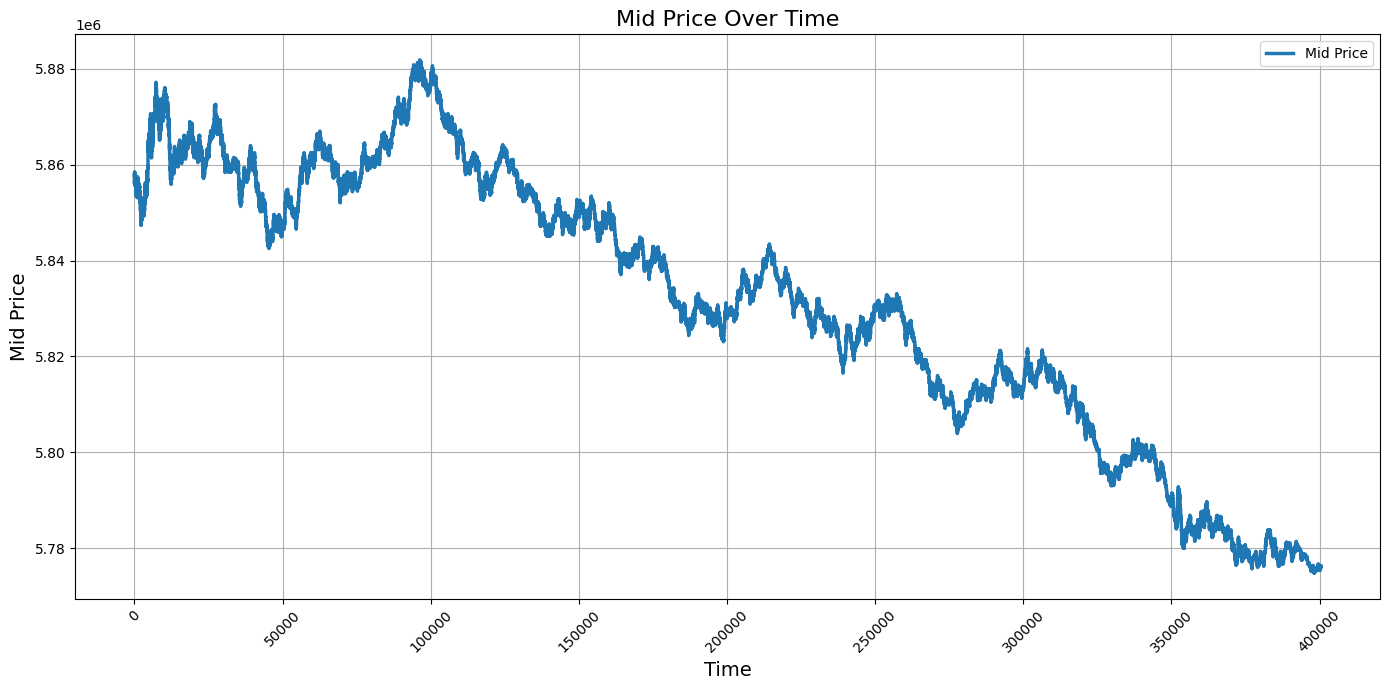

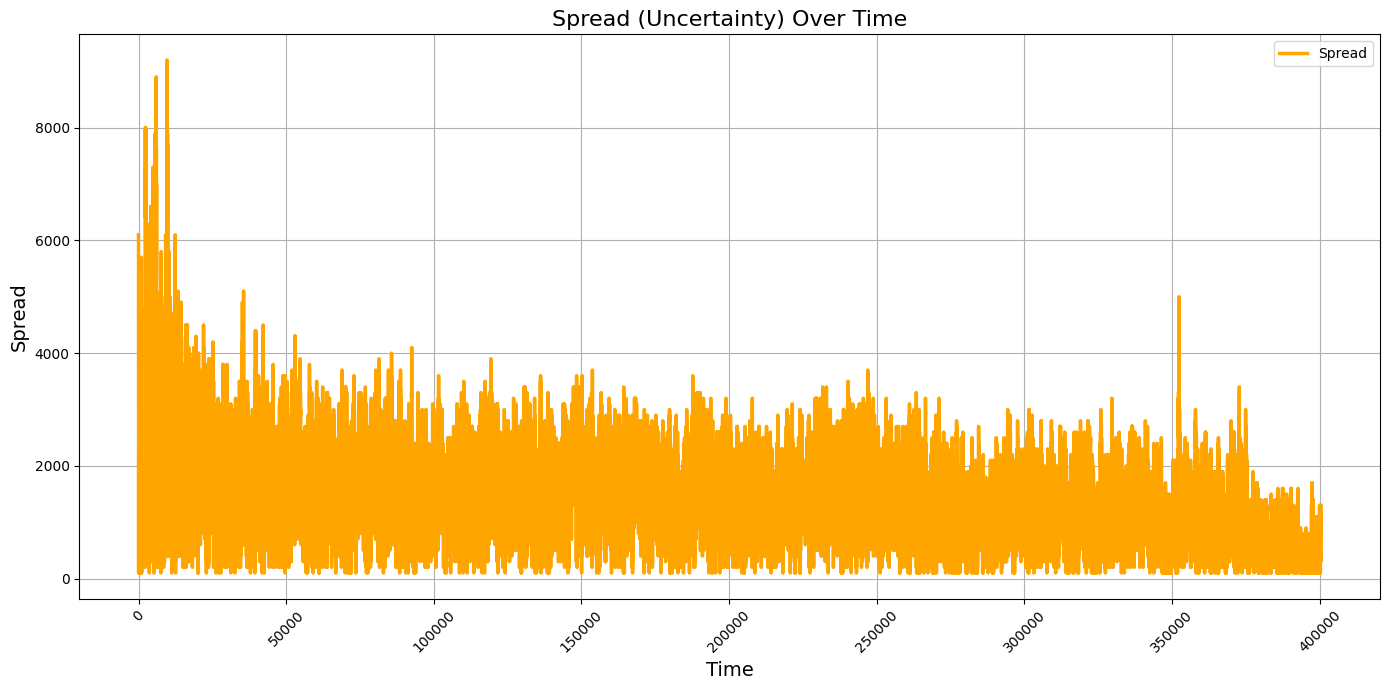

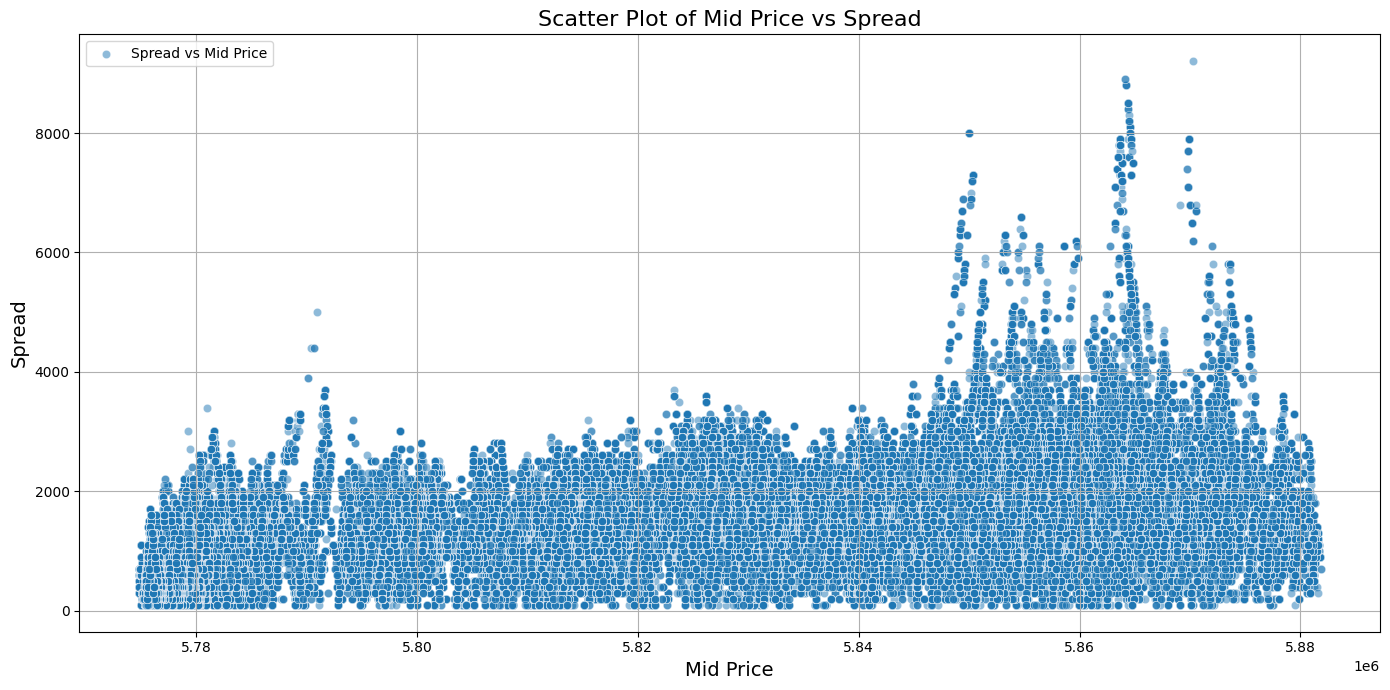

In [4]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df['Mid_Price'], label='Mid Price', linewidth=2.5)
plt.title('Mid Price Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Mid Price', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.lineplot(data=df['Spread'], label='Spread', color='orange', linewidth=2.5)
plt.title('Spread (Uncertainty) Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Spread', fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.scatterplot(x=df['Mid_Price'], y=df['Spread'], label='Spread vs Mid Price', alpha=0.5)
plt.title('Scatter Plot of Mid Price vs Spread', fontsize=16)
plt.xlabel('Mid Price', fontsize=14)
plt.ylabel('Spread', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Load the message dataframe containing information about the trade events.
The main objective is to use a Kalman filter to generate a "filtered" signal from our price data. To get started, I'll be relying on a standard library like pykalman, which comes with pre-implemented Kalman filters. 

This filter typically works best when our data is evenly spaced in time so uniform. Therefore, I'll need to resample our dataset to a frequency where we usually see either one or zero trades. 
I load the message dataframe and check the median between trades in order to choose the best resampling period. 

In [5]:
message_df= pd.read_csv('/Users/leonardodulcetti/Desktop/Algo trading presentation/LOBSTER/AAPL_2012-06-21_34200000_57600000_message_10.csv', names=['Time', 'Type', 'Order_ID', 'Size', 'Price', 'Direction'])
message_df['Time'] = pd.to_datetime(message_df['Time'], unit='s')
message_df = message_df.sort_values(by='Time')
message_df['time_diff'] = message_df['Time'].diff()
time_diffs = message_df['time_diff'].dropna()
median_time_diff = time_diffs.median()
print("The median time between trades is:", median_time_diff)
message_df.set_index('Time', inplace=True)
message_df.head()

The median time between trades is: 0 days 00:00:00.000638857


,Type,Order_ID,Size,Price,Direction,time_diff
Time,,,,,,
1970-01-01 09:30:00.004241176,1,16113575,18,5853300,1,NaT
1970-01-01 09:30:00.004260640,1,16113584,18,5853200,1,0 days 00:00:00.000019464
1970-01-01 09:30:00.004447484,1,16113594,18,5853100,1,0 days 00:00:00.000186844
1970-01-01 09:30:00.025551909,1,16120456,18,5859100,-1,0 days 00:00:00.021104425
1970-01-01 09:30:00.025579546,1,16120480,18,5859200,-1,0 days 00:00:00.000027637


### 5. Resempling trades in order to have a uniform temporal grid 

For explanatory reason, I decided to use a resampling period of '100ms' corresponding to 100 milliseconds. 

Once we have this uniform time grid, we can start applying the Kalman filter. Essentially, the Kalman filter is a Gaussian linear model. It assumes that the true midprice is hidden from us and what we actually observe are noisy trade prices. These trades are modeled as Gaussian distributions with a mean (which is our observation) and some uncertainty. We'll estimate this uncertainty using the Kalman filter too.

Moreover, the Kalman filter also assumes that the true midprice isn't static but behaves more like a Brownian motion or random walk. This means that its changes over time follow Gaussian distributions with specific means and standard deviations. So, by employing the Kalman filter, we aim to track this latent midprice amidst the noisy trade data.

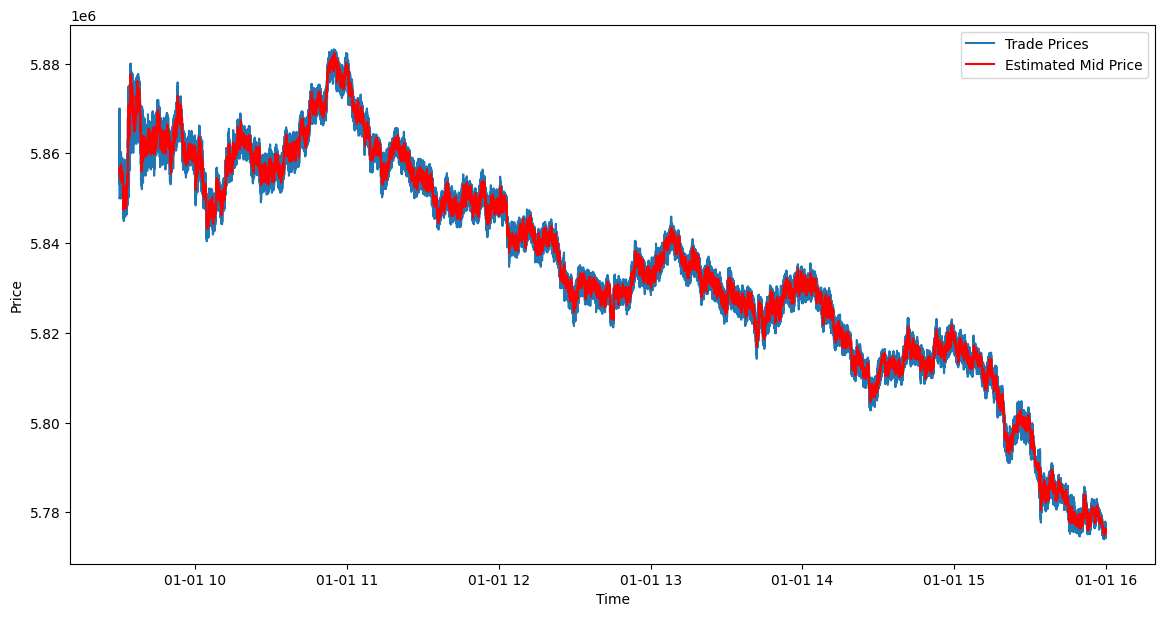

In [6]:
# Filtering  for trades (assuming 'Type' == 1 indicates a trade)
trades_df = message_df[message_df['Type'] == 1]
resampled_trades = trades_df['Price'].resample('100ms').last().ffill()
transition_matrix = [1]
observation_matrix = [1]
initial_state_mean = resampled_trades.iloc[0]
initial_state_covariance = 1
observation_covariance = 1
transition_covariance = 0.01
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance
)

#Fit the Kalman Filter to the trading data. I decided to use 3 iterations to get a better estimate
kf = kf.em(resampled_trades, n_iter=3)
state_means, state_covariances = kf.filter(resampled_trades)
estimated_midprice = pd.Series(state_means.flatten(), index=resampled_trades.index)

# Plotting 
plt.figure(figsize=(14, 7))
plt.plot(resampled_trades.index, resampled_trades, label='Trade Prices')
plt.plot(estimated_midprice.index, estimated_midprice, label='Estimated Mid Price', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### 6. Data visualization of the Kalman mid-price and estiamted error

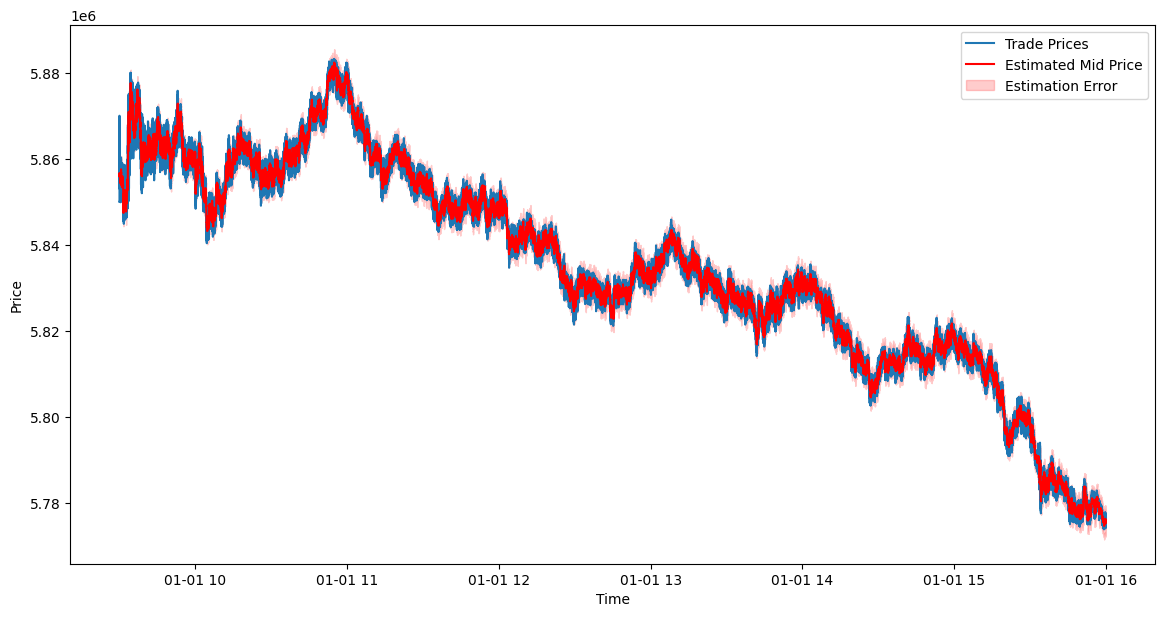

In [7]:
estimated_error = pd.Series(np.sqrt(state_covariances.flatten()), index=resampled_trades.index)

# I scaled the error by a factor of 10 to make it more visible in the plot
estimated_error_scaled = estimated_error * 10 
plt.figure(figsize=(14, 7))
plt.plot(resampled_trades.index, resampled_trades, label='Trade Prices')
plt.plot(estimated_midprice.index, estimated_midprice, label='Estimated Mid Price', color='red')
plt.fill_between(estimated_midprice.index, 
                 estimated_midprice - estimated_error_scaled, 
                 estimated_midprice + estimated_error_scaled, 
                 color='red', alpha=0.2, label='Estimation Error')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

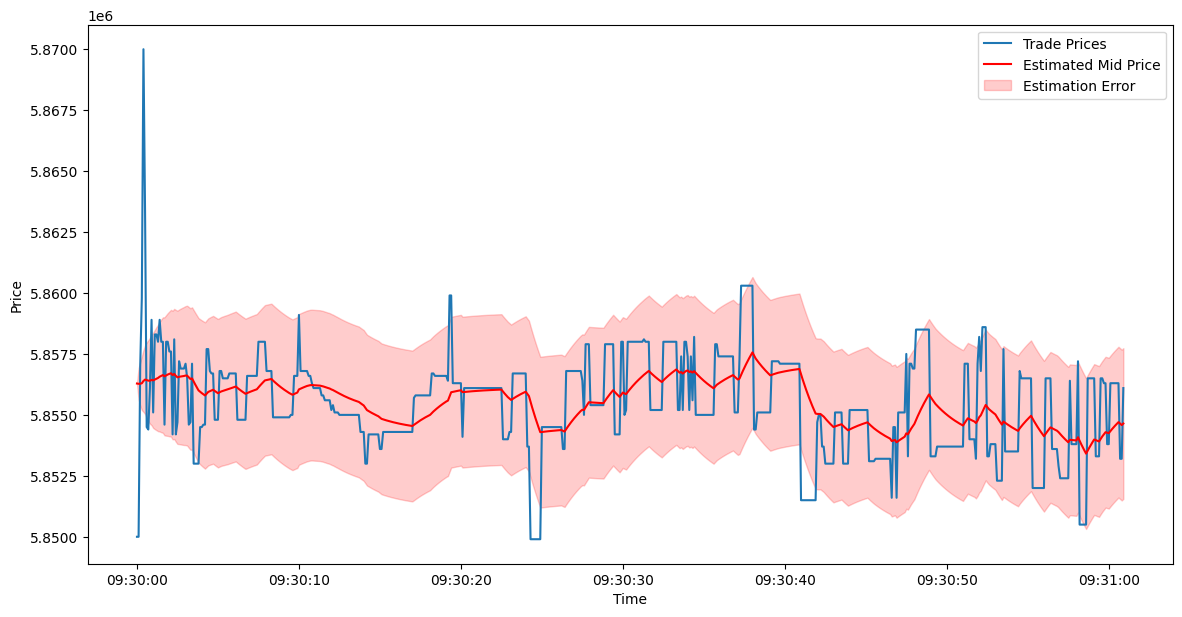

In [8]:
subset_start = '1970-01-01 09:30:00'
subset_end = '1970-01-01 09:31:00'
subset_midprice = estimated_midprice[subset_start:subset_end]
subset_error = estimated_error_scaled[subset_start:subset_end]
subset_trades = resampled_trades[subset_start:subset_end]

plt.figure(figsize=(14, 7))
plt.plot(subset_trades.index, subset_trades, label='Trade Prices')
plt.plot(subset_midprice.index, subset_midprice, label='Estimated Mid Price', color='red')
plt.fill_between(subset_midprice.index, 
                 subset_midprice - subset_error, 
                 subset_midprice + subset_error, 
                 color='red', alpha=0.2, label='Estimation Error')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### Comparison between mid-price from Best Bid and Ask and Mid-Price from Kelman

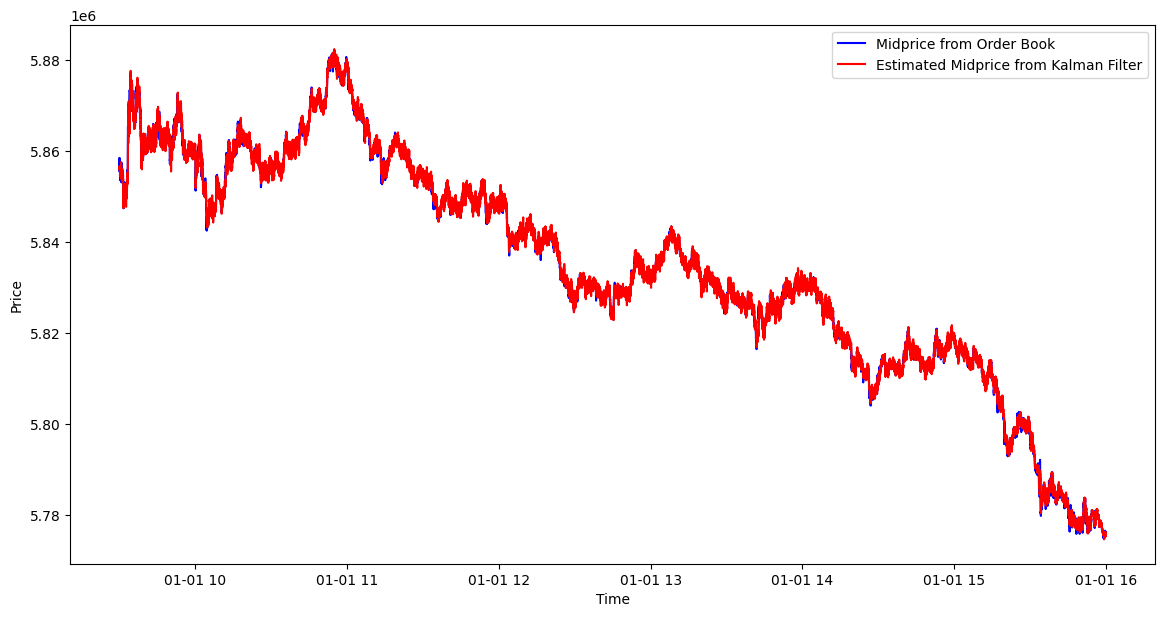

In [9]:
#I resample the order book data to 100ms in order to match the trade data
df.index = message_df.index
df_resampled_midprice =  df['Mid_Price'].resample('100ms').last().ffill()
df_resampled_midprice.head()
# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(df_resampled_midprice.index, df_resampled_midprice, label='Midprice from Order Book', color='blue')
plt.plot(estimated_midprice.index, estimated_midprice, label='Estimated Midprice from Kalman Filter', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Smoothed Estimates: The Kalman Filter provides smoothed estimates by incorporating both past and present information, which can help reduce the impact of noise and sudden fluctuations in the midprice.

### Zoom in a specific interval range to determine the difference 

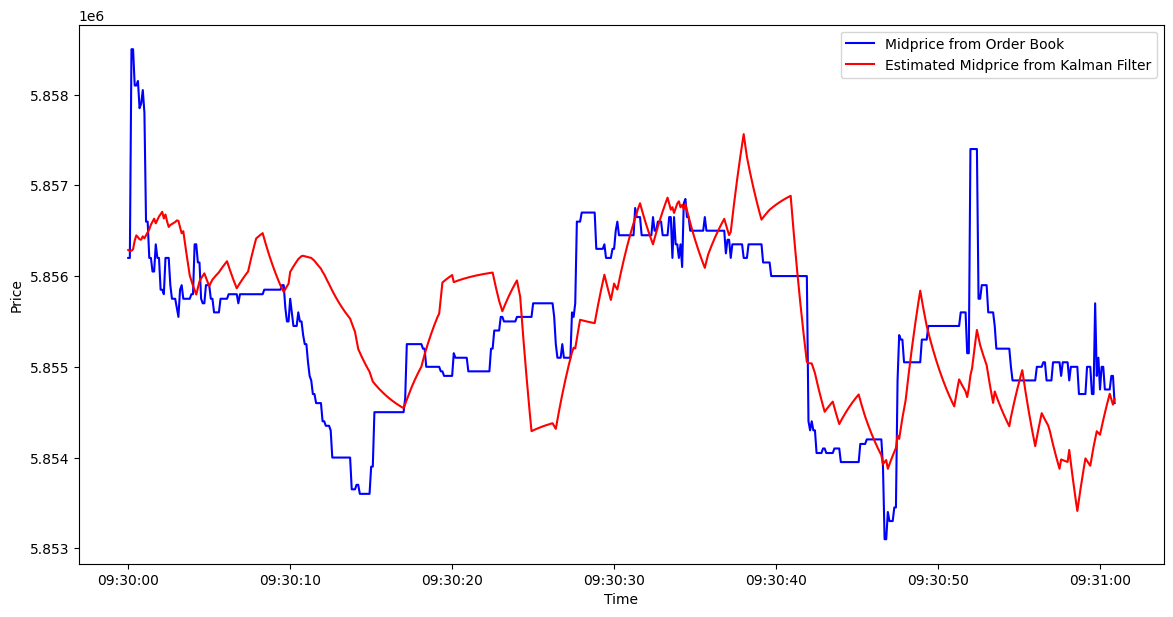

In [10]:
# I select a specific subset of the data to compare
subset_start = '1970-01-01 09:30:00'
subset_end = '1970-01-01 09:31:00'
subset_df_resampled_midprice = df_resampled_midprice[subset_start:subset_end]
subset_estimated_midprice = estimated_midprice[subset_start:subset_end]
subset_df_resampled_midprice.head()
plt.figure(figsize=(14, 7))
plt.plot(subset_df_resampled_midprice.index, subset_df_resampled_midprice, label='Midprice from Order Book', color='blue')
plt.plot(subset_estimated_midprice.index, subset_estimated_midprice, label='Estimated Midprice from Kalman Filter', color='red')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Absolute difference between the two mid-prices 

In [11]:
# Calculate the absolute difference between the two midprice estimates in the same notation of price 
midprice_diff = np.abs(df_resampled_midprice - estimated_midprice)
print(midprice_diff.describe())

count    233995.000000
mean        743.498188
std         557.029611
min           0.001435
25%         309.575766
50%         643.431959
75%        1064.974189
max        9346.493194
dtype: float64


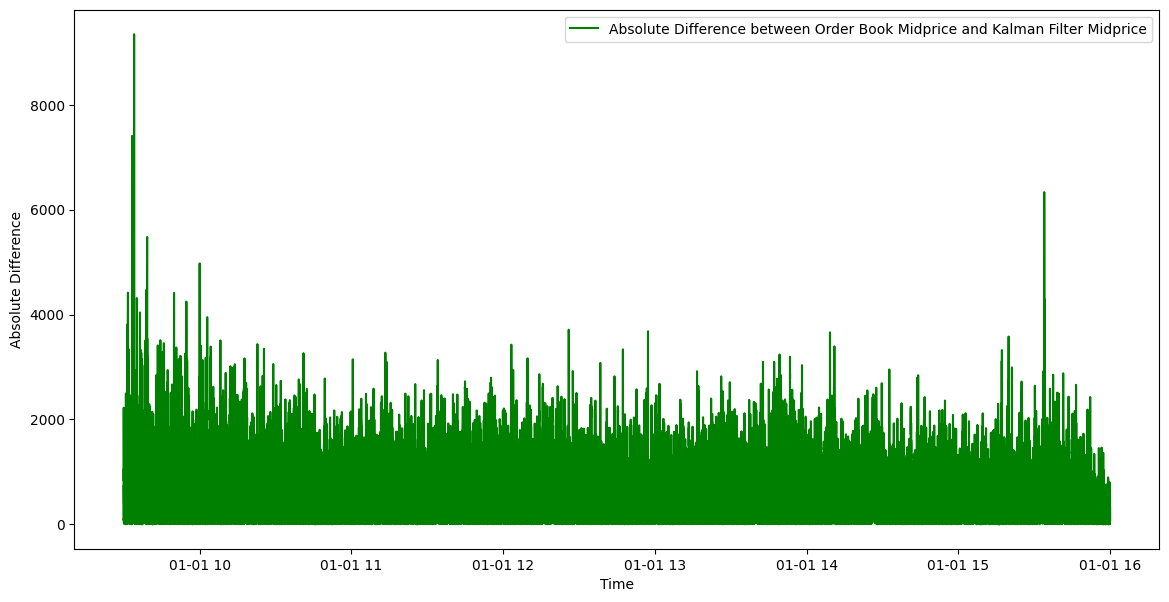

In [12]:
#Plot the absolute difference between the two midprice estimates
plt.figure(figsize=(14, 7))
plt.plot(midprice_diff.index, midprice_diff, label='Absolute Difference between Order Book Midprice and Kalman Filter Midprice', color='green')
plt.xlabel('Time')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()


### Absolute difference of the subset time interval

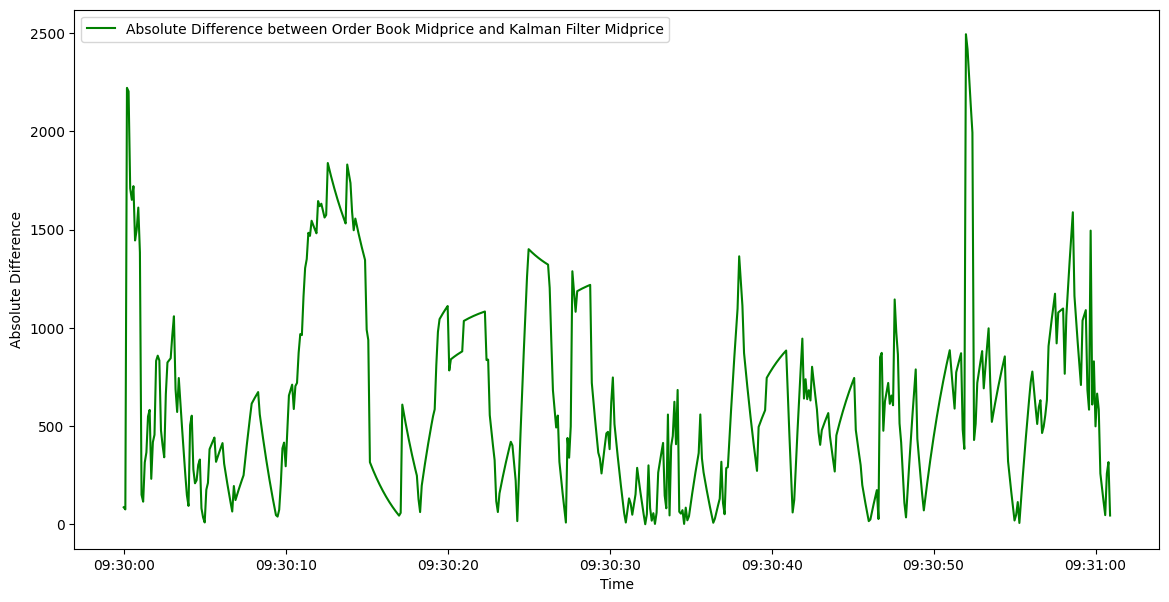

In [13]:
# Now show me the subset of the absolute difference between the two midprice estimates
subset_midprice_diff = midprice_diff[subset_start:subset_end]
plt.figure(figsize=(14, 7))
plt.plot(subset_midprice_diff.index, subset_midprice_diff, label='Absolute Difference between Order Book Midprice and Kalman Filter Midprice', color='green')
plt.xlabel('Time')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()

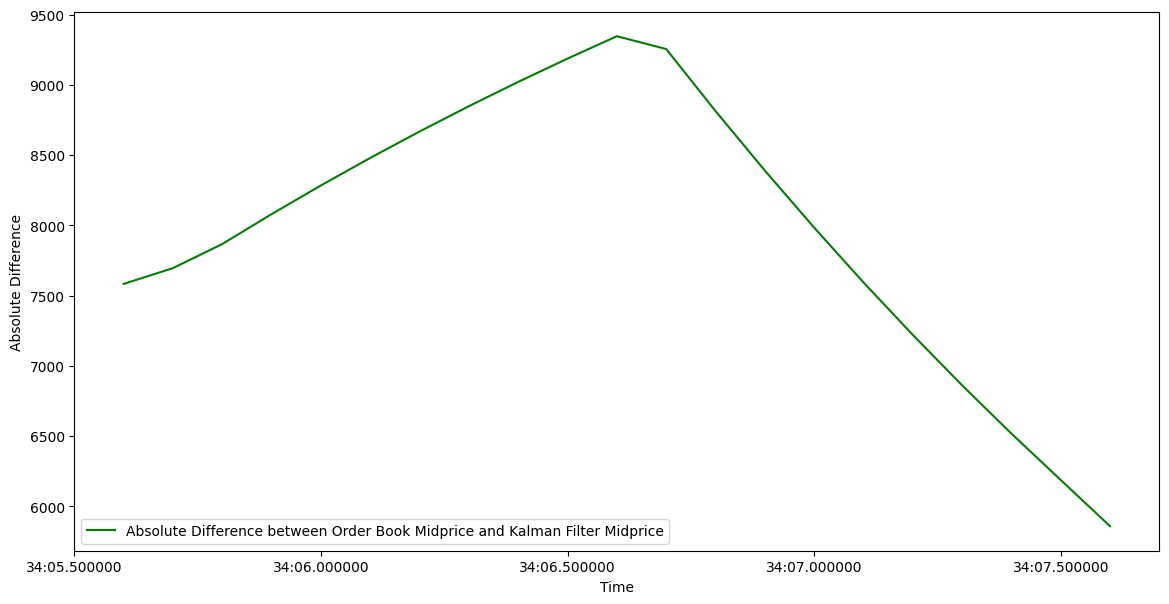

In [14]:
#Plot where the absolute difference is the highest
max_diff = midprice_diff.idxmax()
max_diff_start = max_diff - pd.Timedelta('1s')
max_diff_end = max_diff + pd.Timedelta('1s')
subset_max_diff = midprice_diff[max_diff_start:max_diff_end]
plt.figure(figsize=(14, 7))
plt.plot(subset_max_diff.index, subset_max_diff, label='Absolute Difference between Order Book Midprice and Kalman Filter Midprice', color='green')
plt.xlabel('Time')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()


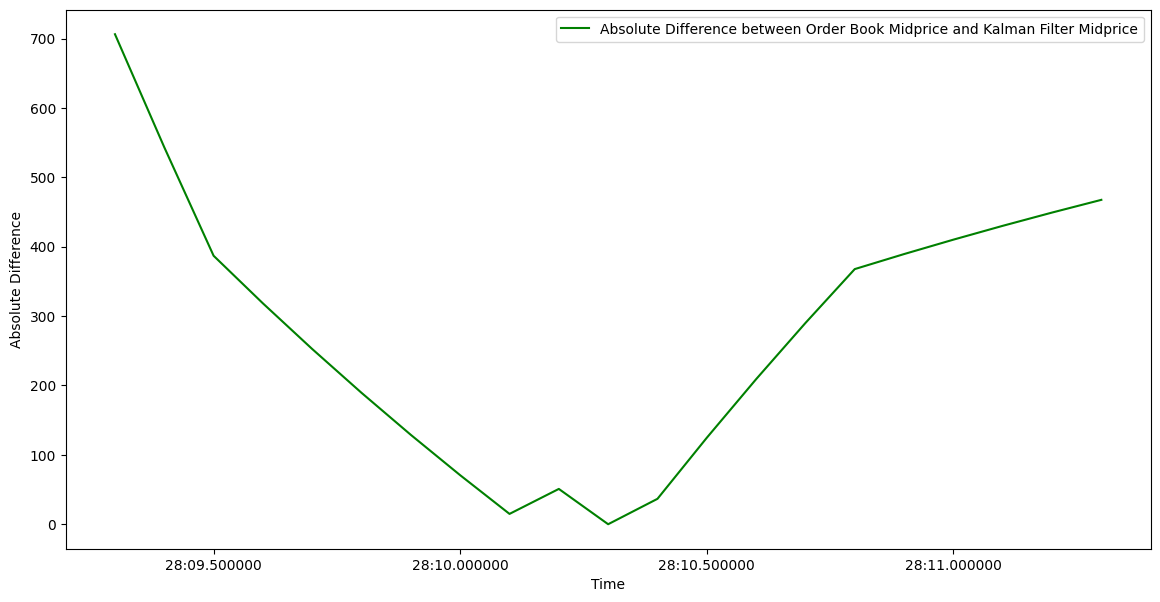

In [15]:
#Plot when the absolute difference is the lowest
min_diff = midprice_diff.idxmin()
min_diff_start = min_diff - pd.Timedelta('1s')
min_diff_end = min_diff + pd.Timedelta('1s')
subset_min_diff = midprice_diff[min_diff_start:min_diff_end]
plt.figure(figsize=(14, 7))
plt.plot(subset_min_diff.index, subset_min_diff, label='Absolute Difference between Order Book Midprice and Kalman Filter Midprice', color='green')
plt.xlabel('Time')
plt.ylabel('Absolute Difference')
plt.legend()
plt.show()

In [16]:
#Save all the important df for representation
df.to_csv('df.csv')
message_df.to_csv('message_df.csv')
resampled_trades.to_csv('resampled_trades.csv')
estimated_midprice.to_csv('estimated_midprice.csv')
estimated_error.to_csv('estimated_error.csv')
midprice_diff.to_csv('midprice_diff.csv')
df_resampled_midprice.to_csv('df_resampled_midprice.csv')   

In [17]:
#resample the message_df, as the resampled_trades
resampled_message_df = message_df.resample('100ms').last().ffill()
resampled_message_df.to_csv('resampled_message_df.csv')
print(resampled_message_df.head())


                         Type    Order_ID   Size      Price  Direction  \
Time                                                                     
1970-01-01 09:30:00.000   1.0  16127688.0  100.0  5850000.0        1.0   
1970-01-01 09:30:00.100   1.0  16127688.0  100.0  5850000.0        1.0   
1970-01-01 09:30:00.200   1.0  16186225.0  100.0  5857000.0        1.0   
1970-01-01 09:30:00.300   1.0  16207442.0  200.0  5859800.0       -1.0   
1970-01-01 09:30:00.400   1.0  16225109.0  300.0  5870000.0       -1.0   

                                        time_diff  
Time                                               
1970-01-01 09:30:00.000 0 days 00:00:00.024627905  
1970-01-01 09:30:00.100 0 days 00:00:00.024627905  
1970-01-01 09:30:00.200 0 days 00:00:00.013393996  
1970-01-01 09:30:00.300 0 days 00:00:00.001068669  
1970-01-01 09:30:00.400 0 days 00:00:00.000155201  


In [18]:
df_resampled_midprice.head()
# Give the name to the column
df_resampled_midprice = df_resampled_midprice.rename('Mid_Price')
df_resampled_midprice.head()

Time
1970-01-01 09:30:00.000    5856200.0
1970-01-01 09:30:00.100    5856200.0
1970-01-01 09:30:00.200    5858500.0
1970-01-01 09:30:00.300    5858500.0
1970-01-01 09:30:00.400    5858100.0
Freq: 100L, Name: Mid_Price, dtype: float64

In [19]:
#Transform the data in a way that you can add more columns
df_resampled_midprice = df_resampled_midprice.to_frame()

In [20]:
df_resampled_midprice.to_csv('df_resampled_midprice.csv')

In [21]:
df_resampled_midprice.head()

,Mid_Price
Time,
1970-01-01 09:30:00.000,5856200.0
1970-01-01 09:30:00.100,5856200.0
1970-01-01 09:30:00.200,5858500.0
1970-01-01 09:30:00.300,5858500.0
1970-01-01 09:30:00.400,5858100.0


In [22]:
df1=df_resampled_midprice

Traditional Successful Trades: 46839
Traditional Average Execution Price: 5835852.607869511
Kalman Successful Trades: 50239
Kalman Average Execution Price: 5836054.957770894


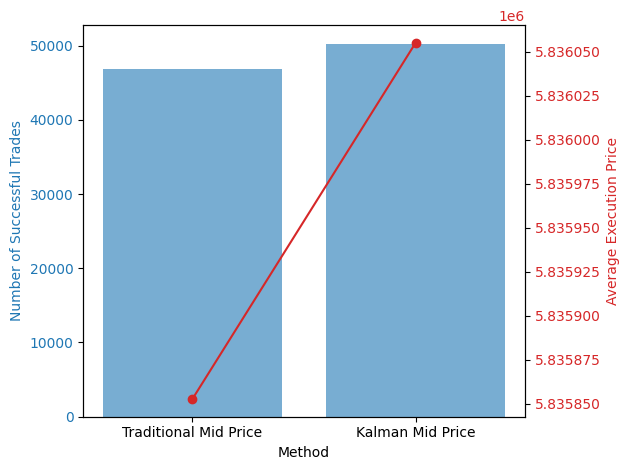

In [23]:
df1['Trade_Price'] = resampled_message_df['Price']
df1['Trade_Size'] = resampled_message_df['Size']
df1['Direction'] = resampled_message_df['Direction']
df1['Spread'] = df['Spread'].resample('100ms').last().ffill()
df1['Kalman_error']= estimated_error

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
filtered_trade_prices, _ = kf.filter(df1['Trade_Price'].values)

# Add the filtered trade prices to the DataFrame
df1['Filtered_Trade_Price'] = filtered_trade_prices

# Define success criteria
success_margin = df1['Spread'] / 2

# Separate buy and sell trades
buy_trades = df1[df1['Direction'] == 1]
sell_trades = df1[df1['Direction'] == -1]

# Ensure the indices of success_margin align with buy_trades and sell_trades
success_margin_buy = success_margin[buy_trades.index]
success_margin_sell = success_margin[sell_trades.index]

# Buy orders are successful if close to bid price
traditional_buy_successful = buy_trades[np.abs(buy_trades['Trade_Price'] - buy_trades['Mid_Price']) <= success_margin_buy]
kalman_buy_successful = buy_trades[np.abs(buy_trades['Filtered_Trade_Price'] - buy_trades['Mid_Price']) <= success_margin_buy]

# Sell orders are successful if close to ask price
traditional_sell_successful = sell_trades[np.abs(sell_trades['Trade_Price'] - sell_trades['Mid_Price']) <= success_margin_sell]
kalman_sell_successful = sell_trades[np.abs(sell_trades['Filtered_Trade_Price'] - sell_trades['Mid_Price']) <= success_margin_sell]
traditional_successful_trades = pd.concat([traditional_buy_successful, traditional_sell_successful])
kalman_successful_trades = pd.concat([kalman_buy_successful, kalman_sell_successful])

traditional_successful_count = len(traditional_successful_trades)
traditional_avg_execution_price = traditional_successful_trades['Trade_Price'].mean()

kalman_successful_count = len(kalman_successful_trades)
kalman_avg_execution_price = kalman_successful_trades['Filtered_Trade_Price'].mean()

print(f"Traditional Successful Trades: {traditional_successful_count}")
print(f"Traditional Average Execution Price: {traditional_avg_execution_price}")
print(f"Kalman Successful Trades: {kalman_successful_count}")
print(f"Kalman Average Execution Price: {kalman_avg_execution_price}")

methods = ['Traditional Mid Price', 'Kalman Mid Price']
successful_trades = [traditional_successful_count, kalman_successful_count]
avg_execution_prices = [traditional_avg_execution_price, kalman_avg_execution_price]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Method')
ax1.set_ylabel('Number of Successful Trades', color=color)
ax1.bar(methods, successful_trades, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Execution Price', color=color)
ax2.plot(methods, avg_execution_prices, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [24]:
#Show me the mean of the spread of the order book and the one of kalman
print(df1['Spread'].mean())
print(estimated_error.mean())

1513.5371794871794
309.2562446803155


In [25]:
df1.to_csv('df1.csv')

In [26]:
df1.tail(5)

,Mid_Price,Trade_Price,Trade_Size,Direction,Spread,Kalman_error,Filtered_Trade_Price
Time,,,,,,,
1970-01-01 15:59:59.500,5775750.0,5777200.0,100.0,-1.0,700.0,NaN,5.776977e+06
1970-01-01 15:59:59.600,5775750.0,5774900.0,100.0,1.0,700.0,NaN,5.775693e+06
1970-01-01 15:59:59.700,5775750.0,5774900.0,100.0,1.0,700.0,NaN,5.775203e+06
1970-01-01 15:59:59.800,5775750.0,5774900.0,100.0,1.0,700.0,NaN,5.775016e+06
1970-01-01 15:59:59.900,5776050.0,5776350.0,52.0,-1.0,1300.0,NaN,5.775840e+06
